#Import the required libraries

In [ ]:
import torch
import matplotlib
import numpy as np
import seaborn as sns
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from __future__ import print_function, division

import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms


Connected to gg colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#evaluation function code

In [ ]:
class get_metric():

    def get_accuracy_graph(epochs, train_acc, val_acc):
        plt.plot(epochs, train_acc, color='#006BA4')
        plt.plot(epochs, val_acc, color='#FF800E')
        plt.grid(b=True, which='major', color='lightgray')
        plt.grid(b=True, which='minor', color='lightgray')
        plt.xticks(np.arange(0, 45, 5))
        plt.yticks(np.arange(0.5, 1, 0.05))
        plt.rcParams['figure.figsize'] = (8, 6)
        plt.rcParams['figure.dpi'] = 600
        plt.xlabel("Number of Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training Accuracy vs Validation Accuracy")
        plt.legend(['Training Acc.', 'Validation Acc.'], loc='lower right')
        plt.show()

    def get_loss_graph(epochs, train_losses, val_losses):  # draw validation and train loss graphs
        matplotlib.rcdefaults()
        plt.plot(epochs, train_losses, color='#006BA4')
        plt.plot(epochs, val_losses, color='#FF800E')
        plt.grid(b=True, which='major', color='lightgray')
        plt.grid(b=True, which='minor', color='lightgray')
        plt.xticks(np.arange(0, 45, 5))
        plt.yticks(np.arange(0, 1.2, 0.2))
        plt.rcParams['figure.dpi'] = 600
        plt.xlabel("Number of Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss vs Validation Loss")
        plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
        plt.show()

    def test_label_predictions(model, device, test_loader):  # calculate outputs on test dataset for get metrics
        model.eval()
        actuals = []
        predictions = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                prediction = output.argmax(dim=1, keepdim=True)
                actuals.extend(target.view_as(prediction))
                predictions.extend(prediction)
        return [i.item() for i in actuals], [i.item() for i in predictions]

    def test_label_predictions_el2(model_0,model_1,model_2,model_3, device, test_loader):

        actuals = []
        predictions = []

        with torch.no_grad():

            for data, target in test_loader:
                data, target = data.to(device), target.to(device)

                outputs_0 = model_0(data)
                _, predicted_0 =torch.max(outputs_0.data, 1)

                outputs_1 = model_1(data)
                _, predicted_1 =torch.max(outputs_1.data, 1)

                outputs_2 = model_2(data)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(data)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                size=final_pred.size()

                for i in range(0,(size[0])):
                    a=0
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            final_pred[i]=1

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1) :

                        a+=1
                        if predicted_3[i].item()==0:
                            final_pred[i]=0

                        if predicted_3[i].item()!=0:
                            final_pred[i]=1
                    if a==0:
                        final_pred[i]=predicted_2[i]
                actuals.extend(target.view_as(final_pred))
                predictions.extend(final_pred)
        return [i.item() for i in actuals], [i.item() for i in predictions]

    def test_model(model ,device, test_loader):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print('Correct Prediction: {:d}  Total Images: {:d}'.format(correct, total))
        print('Test Accuracy = {:f}'.format(correct / total))

    def test_model_el2(model_0,model_1,model_2,model_3,device, test_loader):

        correct = 0
        total = 0

        with torch.no_grad():
            for data in test_loader:

                images, labels = data[0].to(device), data[1].to(device)

                outputs_0 = model_0(images)
                _, predicted_0 =torch.max(outputs_0.data, 1)

                outputs_1 = model_1(images)
                _, predicted_1 =torch.max(outputs_1.data, 1)

                outputs_2 = model_2(images)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(images)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                size=final_pred.size()

                for i in range(0,(size[0])):
                    a=0
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            final_pred[i]=1

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1):

                        a+=1

                        if predicted_3[i].item()==0:
                            final_pred[i]=0
                        if predicted_3[i].item()!=0:
                            final_pred[i]=1
                    if a==0:
                        final_pred[i]=predicted_2[i]

                total += labels.size(0)
                correct += (final_pred == labels).sum().item()
        print('Correct Prediction: {:d}  Total Images: {:d}'.format(correct, total))
        print('Test Accuracy = {:f}'.format(correct / total))

    def get_classification_report(truth, predict):  # create classification report for each class with scikit-learn library
        print('Classification Report :\n', classification_report(truth, predict))

    def get_confusion_matrix(actuals, predictions):  # create confusion matrix for each class with scikit-learn library
        matplotlib.rcdefaults()
        print('Confusion matrix:\n',confusion_matrix(actuals, predictions))
        cf_matrix=confusion_matrix(actuals, predictions)
        sns.heatmap(cf_matrix, annot=True,fmt='g', cmap='Blues')

    def get_cohen_kappa(actuals, predictions):  # get cohen kapa score for   determine model performance
        cps = cohen_kappa_score(actuals, predictions)
        print('Kappa Score of this model:\n', cps)

    def test_class_probabilities(model, device, test_loader, which_class):

        truths = []
        probabilities = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data).cuda().cpu()
                prediction = output.argmax(dim=1, keepdim=True)
                truths.extend(target.view_as(prediction) == which_class)
                probabilities.extend(np.exp(output[:, which_class]))
        return [i.item() for i in truths], [i.item() for i in probabilities]
    def test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, test_loader, which_class):

        truths = []
        probabilities = []

        with torch.no_grad():
            for data, target in test_loader:

                data, target = data.to(device), target.to(device)

                outputs_0 = model_0(data)
                _, predicted_0 =torch.max(outputs_0.data, 1)

                outputs_1 = model_1(data)
                _, predicted_1 =torch.max(outputs_1.data, 1)

                outputs_2 = model_2(data)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(data)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                out=outputs_1
                size=final_pred.size()

                for i in range(0,(size[0])):
                    a=0
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            #final_pred[i]=1
                            out[i]=outputs_1[i]

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                            out[i]=outputs_1[i]
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1):

                        a+=1

                        if predicted_3[i].item()==0:
                            #final_pred[i]=0
                            out[i]=outputs_3[i]

                        if predicted_3[i].item()!=0:
                            #final_pred[i]=1
                            out[i]=outputs_3[i]
                    if a==0:
                        #final_pred[i]=predicted_2[i]
                        out[i]=outputs_2[i]
                prediction = out.argmax(dim=1, keepdim=True)
                truths.extend(target.view_as(prediction) == which_class)
                probabilities.extend(np.exp(out.cuda().cpu()[:, which_class]))
        return [i.item() for i in truths], [i.item() for i in probabilities]

    def get_roc_curves_el2(model_0,model_1,model_2,model_3, device, data):  # draw Roc curves and calculate auc score for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        actuals, class_probabilities = get_metric.test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, data, 0)
        fpr[0], tpr[0], _ = roc_curve(actuals, class_probabilities)
        roc_auc[0] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, data, 1)
        fpr[1], tpr[1], _ = roc_curve(actuals, class_probabilities)
        roc_auc[1] = roc_auc_score(actuals, class_probabilities)

        print("Auc Score For Each Class: ", roc_auc)

        matplotlib.rcdefaults()
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(2), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
                     label='ROC curve of class {0} (area = {1:0.4f})'
                           ''.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()

    def get_roc_curves(model, device, data):  # draw Roc curves and calculate auc score for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 0)
        fpr[0], tpr[0], _ = roc_curve(actuals, class_probabilities)
        roc_auc[0] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 1)
        fpr[1], tpr[1], _ = roc_curve(actuals, class_probabilities)
        roc_auc[1] = roc_auc_score(actuals, class_probabilities)

        print("Auc Score For Each Class: ", roc_auc)

        matplotlib.rcdefaults()
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(2), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
                     label='ROC curve of class {0} (area = {1:0.4f})'
                           ''.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()

#Prepared data

In [ ]:
data_dir = '/content/drive/MyDrive/data'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

In [ ]:
pretrained_size = 320

pretrained_means = [0.485,0.456,0.406]

pretrained_stds= [0.229,0.224,0.225]

batch_size=8

data_transforms = {

    'train': transforms.Compose([
        transforms.Resize((pretrained_size,pretrained_size)),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomRotation(10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means,
                                                std = pretrained_stds)
    ]),
    'val': transforms.Compose([
        transforms.Resize((pretrained_size,pretrained_size)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means,
                                                std = pretrained_stds)
    ]),
                   }
print("Initializing Datasets and Dataloaders...\n")
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True) for x in ['train', 'val']}
device = torch.device("cuda:0")
dataset_sizes ={x:len(image_datasets[x]) for x in ['train','val']}

Initializing Datasets and Dataloaders...



In [ ]:
# Class names convert to index
image_datasets['train'].class_to_idx
class_names=image_datasets['train'].classes
print(">>Class Names: {}\n".format(image_datasets['train'].classes))
print(">>Class Index: {}\n".format(image_datasets['train'].class_to_idx))
print(">>Number of images in training={}\n".format(dataset_sizes['train']))
print(">>Number of images in test={}\n".format(dataset_sizes['val']))
print("    Number of steps for training set={}\n".format(len(dataloaders['train'])))
print("    Number of steps for test set={}\n".format(len(dataloaders['val'])))
# 1:positive #0:negative

>>Class Names: ['fractured', 'non_fractured']

>>Class Index: {'fractured': 0, 'non_fractured': 1}

>>Number of images in training=4986

>>Number of images in test=818

    Number of steps for training set=624

    Number of steps for test set=103



#training function code

In [ ]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    ghost=True
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # if isinstance(outputs, tuple):
                    #   outputs, aux = outputs
                    # else:
                    #     aux = None
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.detach() * inputs.size(0) #.item()
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss/ dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #Losses and accuracy per epochs are stored in array for plot graphs
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'val':
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
            torch.cuda.empty_cache()

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        torch.cuda.empty_cache()
    # Determine total traning time
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    # Print best validation accuracy
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(best_model_wts, "./model.pth")
    return model

#Models

##AlexNet

In [ ]:
model_ft=models.alexnet(pretrained=True)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), betas=(0.9,0.999), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,20)

##VGG16, VGG19

In [ ]:
model_ft =models.vgg19(pretrained=True)#models.vgg16,models.vgg19
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Sequential(nn.Linear(num_ftrs, 2))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), betas=(0.9,0.999), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,20)

##resnet18, resnet34, resnet50, resnet101, resnet152

In [ ]:
model_ft=models.resnet152(pretrained=True) #models.resnet18 models.resnet34,models.resnet50,models.resnet101,models.resnet152,
num_ftrs = model_ft.fc.in_features
model_ft.fc =nn.Sequential(nn.Linear(num_ftrs, 2),
nn.Sigmoid())

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), betas=(0.9,0.999), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,20)

##efficientnet-b0, efficientnet-b1, efficientnet-b7, efficientnet-V2

In [ ]:
!pip install efficientnet_pytorch


In [ ]:
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

In [ ]:
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b0')
num_ftrs = efficientnet_model._fc.in_features
efficientnet_model._fc = nn.Sequential(
    nn.Linear(num_ftrs, 2),
    nn.Sigmoid()
)
model_ft = efficientnet_model
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), betas=(0.9,0.999), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,20)

##Dense169, Dense201

In [ ]:
model_ft =models.densenet169(pretrained=True)#models.densenet169,models.densenet201
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Sequential(nn.Linear(num_ftrs, 2),
nn.Sigmoid())

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), betas=(0.9,0.999), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,20)

##MobileNetV2, MobileNetV3

In [ ]:
model_ft=models.mobilenet_v3_small(pretrained=True)#models.mobilenet_v2, models.mobilenet_v3
num_ftrs = model_ft.classifier[0].in_features
model_ft.classifier =nn.Sequential(nn.Linear(num_ftrs, 2),
nn.Sigmoid())
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), betas=(0.9,0.999), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,20)

##RegNet_y16

In [ ]:
model_ft = models.regnet_y_16gf(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc= nn.Sequential(nn.Linear(num_ftrs, 2))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), betas=(0.9,0.999), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,20)

##RepVGG

In [ ]:
!git clone https://github.com/DingXiaoH/RepVGG.git


Cloning into 'RepVGG'...
remote: Enumerating objects: 581, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 581 (delta 191), reused 174 (delta 138), pack-reused 345
Receiving objects: 100% (581/581), 485.19 KiB | 12.13 MiB/s, done.
Resolving deltas: 100% (347/347), done.


In [ ]:
import torch
import torch.nn as nn
from repvgg import create_RepVGG_A0

In [ ]:
import torch
import torch.nn as nn
from repvgg import create_RepVGG_A0  # Adjust the import path if necessary

# Function to load the pretrained model with weights
def load_pretrained_repvgg(model, weights_path):
    checkpoint = torch.hub.load_state_dict_from_url(weights_path, map_location='cpu')
    if 'state_dict' in checkpoint:
        checkpoint = checkpoint['state_dict']
    model.load_state_dict(checkpoint)
    return model

# Load the RepVGG model
model_ft = create_RepVGG_A0(deploy=False)

# Load the pretrained weights
weights_url = 'https://github.com/DingXiaoH/RepVGG/releases/download/v1.0/RepVGG-A0-train.pth'
model_ft = load_pretrained_repvgg(model_ft, weights_url)

# Modify the classifier part
num_ftrs = model_ft.head.in_features
model_ft.head = nn.Sequential(
    nn.Linear(num_ftrs, 2),
    nn.Sigmoid()
)

In [ ]:
#model_ft.load_state_dict(torch.load("./model.pth"))

In [ ]:
# Model send to GPU
model_ft = model_ft.to(device)

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.Adam(model_ft.parameters(), betas=(0.9,0.999), lr=0.0001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,20)

Epoch 0/19
----------
train Loss: 0.4946 Acc: 0.8117
val Loss: 0.4810 Acc: 0.8301

Epoch 1/19
----------
train Loss: 0.4592 Acc: 0.8504
val Loss: 0.4528 Acc: 0.8582

Epoch 2/19
----------
train Loss: 0.4517 Acc: 0.8580
val Loss: 0.4516 Acc: 0.8582

Epoch 3/19
----------
train Loss: 0.4420 Acc: 0.8664
val Loss: 0.4489 Acc: 0.8582

Epoch 4/19
----------
train Loss: 0.4413 Acc: 0.8672
val Loss: 0.4622 Acc: 0.8435

Epoch 5/19
----------
train Loss: 0.4310 Acc: 0.8787
val Loss: 0.4536 Acc: 0.8570

Epoch 6/19
----------
train Loss: 0.4276 Acc: 0.8803
val Loss: 0.4717 Acc: 0.8362

Epoch 7/19
----------
train Loss: 0.4280 Acc: 0.8807
val Loss: 0.4425 Acc: 0.8667

Epoch 8/19
----------
train Loss: 0.4226 Acc: 0.8891
val Loss: 0.4671 Acc: 0.8386

Epoch 9/19
----------
train Loss: 0.4255 Acc: 0.8843
val Loss: 0.4474 Acc: 0.8643

Epoch 10/19
----------
train Loss: 0.4016 Acc: 0.9099
val Loss: 0.4351 Acc: 0.8655

Epoch 11/19
----------
train Loss: 0.3935 Acc: 0.9148
val Loss: 0.4227 Acc: 0.8851

Ep

 #  Test

In [ ]:
get_metric.test_model(model_ft,device,dataloaders['val'])

Correct Prediction: 737  Total Images: 818
Test Accuracy = 0.900978


In [ ]:
actuals, predictions = get_metric.test_label_predictions(model_ft, device, dataloaders['val'])

In [ ]:
get_metric.get_classification_report(actuals, predictions)

Classification Report :
               precision    recall  f1-score   support

           0       0.76      0.65      0.70       144
           1       0.93      0.96      0.94       674

    accuracy                           0.90       818
   macro avg       0.84      0.80      0.82       818
weighted avg       0.90      0.90      0.90       818



Confusion matrix:
 [[ 93  51]
 [ 30 644]]


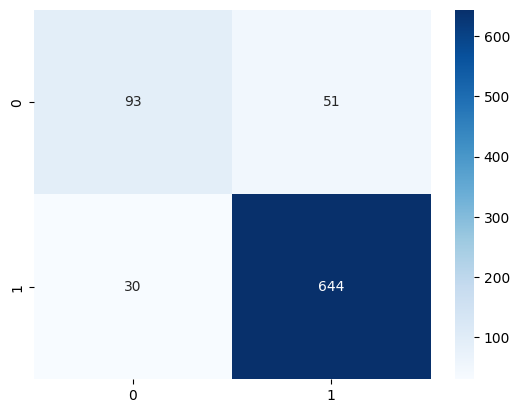

In [ ]:
get_metric.get_confusion_matrix(actuals, predictions)

In [ ]:
get_metric.get_cohen_kappa(actuals, predictions)

Kappa Score of this model:
 0.6378988097189887


In [ ]:
get_metric.get_roc_curves(model_ft, device,  dataloaders['val'])